<a href="https://colab.research.google.com/github/Jaksta1/Uczenie_Maszynowe_2025/blob/main/Jakub_Kownacki_praca_domowa_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Primary question

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

-------------------------------
# 1. Wygenerowanie zbioru danych "mouse"
-------------------------------

In [2]:
# 300 punktów z N([0,0], [[0.16,0],[0,0.16]])
data1 = np.random.multivariate_normal([0, 0], [[0.16, 0.0], [0.0, 0.16]], 300)
# 100 punktów z N([0.8,0.8], [[0.04,0],[0,0.04]])
data2 = np.random.multivariate_normal([0.8, 0.8], [[0.04, 0.0], [0.0, 0.04]], 100)
# 100 punktów z N([-0.8,0.8], [[0.04,0],[0,0.04]])
data3 = np.random.multivariate_normal([-0.8, 0.8], [[0.04, 0.0], [0.0, 0.04]], 100)
# Połączenie wszystkich danych
X = np.vstack([data1, data2, data3])
# Oryginalne etykiety (przyjmujemy, że:
# pierwsze 300 punktów -> klaster 0, kolejne 100 -> klaster 1, ostatnie 100 -> klaster 2)
true_labels = np.array([0]*300 + [1]*100 + [2]*100)

-------------------------------
# 2. Dopasowanie metody EM w modelu GMM do danych "mouse"
-------------------------------

In [3]:
# Metoda EM w modelu GMM
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=0)
gmm.fit(X)


GaussianMixture(n_components=3, random_state=0)

-------------------------------
# 3. Przygotowanie siatki punktów do wizualizacji granic decyzyjnych
-------------------------------

In [4]:
# Określenie zakresów
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 2000),
                     np.linspace(y_min, y_max, 2000))
grid = np.c_[xx.ravel(), yy.ravel()]

# Predykcja etykiet na siatce
gmm_grid = gmm.predict(grid)

-------------------------------
# 4. Wizualizacja wyników
-------------------------------

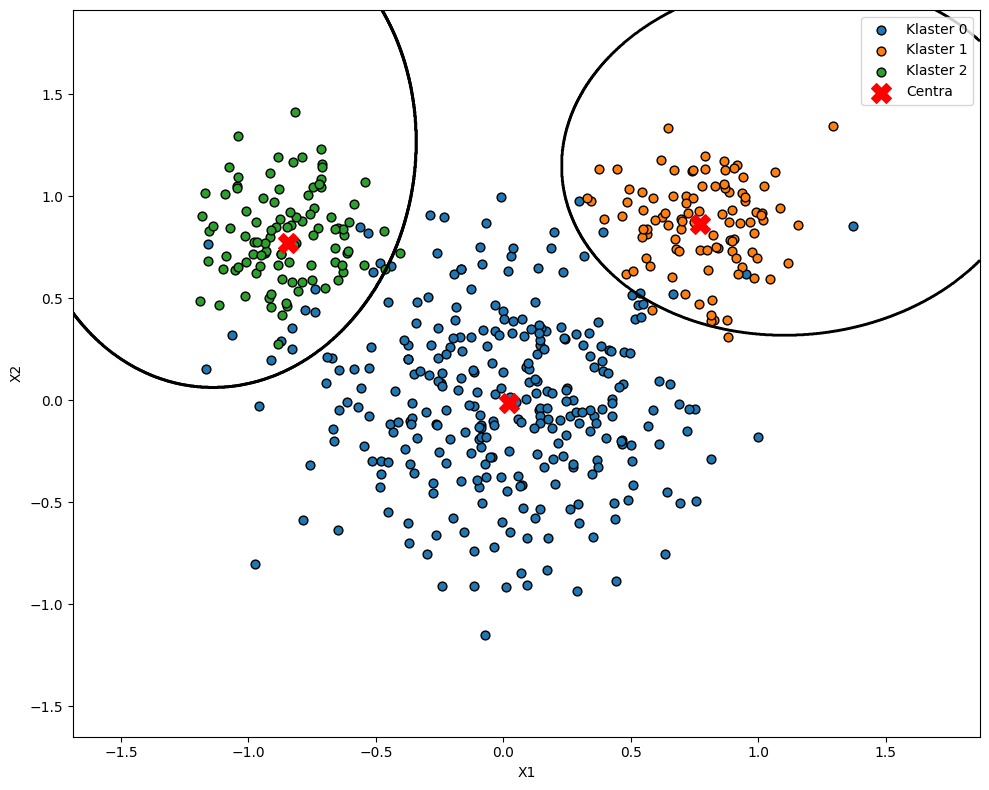

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Rysujemy linie podziału obszarów decyzyjnych
ax.contour(xx, yy, gmm_grid.reshape(xx.shape), levels=[0.5, 1.5], colors='k', linewidths=2)

colors = ['tab:blue', 'tab:orange', 'tab:green']
for label, color in zip(np.unique(true_labels), colors):
    cluster_points = X[true_labels == label]
    # Rysujemy oryginalne punkty
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1],
               label=f'Klaster {label}', edgecolor='k', s=40, color=color)

# Rysujemy środki klastrów
ax.scatter(gmm.means_[:, 0], gmm.means_[:, 1], marker='X', s=200,
           c='red', label='Centra')

ax.legend()
ax.set_xlabel('X1')
ax.set_ylabel('X2')
plt.tight_layout()
plt.show()

Na wykresie przedstawiono oryginalny zbiór danych "mouse" użyty na zajęciach z podziałem na poszczególne klastry,centra wszystkich klastrów oraz linie granic decyzyjnych algorytmu klasyfikacji EM w modelu GMM. \\
Jak widać algorytm EM dość dobrze odwzorowuje oryginalny podział na klastry, jedynie na granicach klastrów 0 i 1 oraz 0 i 2 znajdują się wymieszane punkty z obu klastrów, z których niektóre są nieprawidłowo przypisane.\
Warto zauważyć, że algorytm EM wyznaczył granice decyzyjne dla klastrów 1 i 2 w postaci elips. Natomiast wszystkie punkty poza tymi elipsami zostają zakwalifikowane do klastra 0, nawet jeśli wybierzemy punkty z prawego lub lewego górnego rogu wykresu, co wydaje się nieintuicyjne, ponieważ spodziewalibyśmy się, że skoro znacznie bliżej znajduje się centrum innego klastra to do niego zostanie przypisany dany punkt.
Dzieje się tak, ponieważ algorytm EM w modelu GMM wyznacza granice decyzyjne na podstawie porównania posteriorów dla poszczególnych klastrów. Punkty z klastra 0 pochodzą z rozkładu normalnego o większej wariancji niż punkty z klastrów 1 i 2, zatem oddalając się od centrów klastrów w pewnym momencie gęstość a posteriori dla klastra 0 stanie się większa niż pozostałych klastrów, co spowoduje nieintuicyjne przypisanie punktów do klastra 0.


# Secondary question

Do określenia liczby klastrów w oryginalnych danych użyjemy następujących kryteriów:
#AIC (Kryterium informacyjne Akaike)
AIC obliczamy ze wzoru
$\mathrm{AIC} = 2p - 2\ln(L)$

gdzie p -- liczba parametrów modelu, L  -- zmaksymalizowana wartość funkcji wiarygodności dla modelu.

Niższa wartość AIC sugeruje, że model jest lepszy, przy jednoczesnym uwzględnieniu jego złożoności.

#BIC (Kryterium informacyjne Bayesa)
BIC obliczamy ze wzoru:
$\mathrm{BIC} = \ln(n)p - 2\ln(L)$

gdzie n -- liczba obserwacji, p oraz L mają to samo znaczenie jak w AIC.

BIC stosuje silniejszą karę za złożoność modelu niż AIC, szczególnie przy dużej liczbie obserwacji. Tak samo jak w przypadku AIC niższa wartość BIC sugeruje, że model jest lepszy.
#Wskaźnik sylwetki
Współczynnik zdefiniowany na zajęciach. Przyjmuje wartości między -1 a 1, a wyższe wartości sugerują, że dane są dobrze pogrupowane.

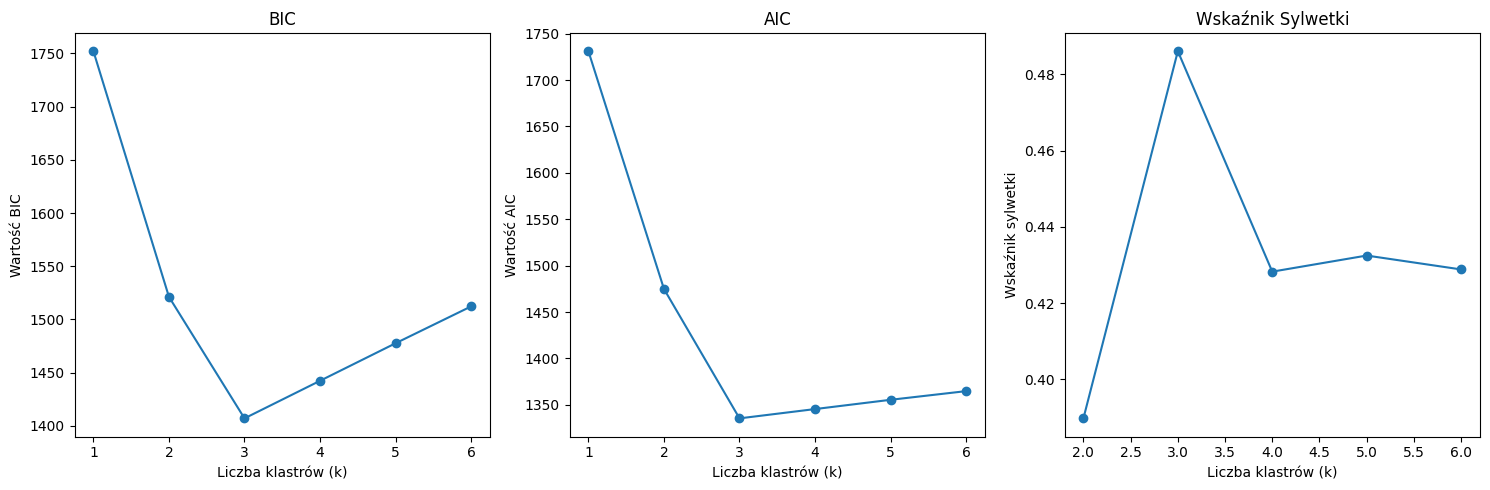

In [6]:
from sklearn.metrics import silhouette_score
# Zakres liczby klastrów, który chcemy przetestować
ks = range(1, 7)  # sprawdzamy od 1 do 6 klastrów

bic_scores = []
aic_scores = []
silhouette_scores = []

for k in ks:
    # Tworzymy i dopasowujemy model GMM z k klastrami
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=0)
    gmm.fit(X)

    # Zapisujemy wartości BIC i AIC
    bic_scores.append(gmm.bic(X))
    aic_scores.append(gmm.aic(X))

    # Współczynnik sylwetki można obliczyć tylko, jeśli k > 1
    if k > 1:
        labels = gmm.predict(X)
        s_score = silhouette_score(X, labels)
        silhouette_scores.append(s_score)
    else:
        silhouette_scores.append(np.nan)  # dla k=1 nie definiujemy silhouette score

# Wizualizacja wyników
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# BIC
ax[0].plot(ks, bic_scores, marker='o')
ax[0].set_title('BIC')
ax[0].set_xlabel('Liczba klastrów (k)')
ax[0].set_ylabel('Wartość BIC')

# AIC
ax[1].plot(ks, aic_scores, marker='o')
ax[1].set_title('AIC')
ax[1].set_xlabel('Liczba klastrów (k)')
ax[1].set_ylabel('Wartość AIC')

# Silhouette
ax[2].plot(ks, silhouette_scores, marker='o')
ax[2].set_title('Wskaźnik Sylwetki')
ax[2].set_xlabel('Liczba klastrów (k)')
ax[2].set_ylabel('Wskaźnik sylwetki')

plt.tight_layout()
plt.show()


# Wynik dla danych "mouse"
Dla danych "mouse" otrzymujemy, że AIC i BIC osiągają minimum dla liczby klastrów równej 3, wskaźnik sylwetki natomiast osiąga maksimum dla 3 klastrów, zatem na podstawie tych trzech wskaźników możemy stwierdzić, że oryginalne dane są podzielone na prawdopodobnie 3 klastry.

--------------------
Wygenerowanie danych 3D z 5 klastrami
--------------------

In [7]:
# 300 punktów z N([0,0,0], [[0.16,0,0],[0,0.16,0],[0,0,0.16]])
data1 = np.random.multivariate_normal([0, 0, 0], [[0.16, 0.0, 0.0], [0.0, 0.16, 0.0], [0.0, 0.0, 0.16]], 300)
# 100 punktów z N([0.8,0.8,0.8], [[0.04,0,0],[0,0.04,0],[0,0,0.04]])
data2 = np.random.multivariate_normal([0.8, 0.8, 0.8], [[0.04, 0.0, 0.0], [0.0, 0.04, 0.0], [0.0, 0.0, 0.04]], 100)
# 100 punktów z N([-0.8,0.8,-0.8], [[0.04,0,0],[0,0.04,0],[0,0,0.04]])
data3 = np.random.multivariate_normal([-0.8, 0.8, -0.8], [[0.04, 0.0, 0.0], [0.0, 0.04, 0.0], [0.0, 0.0, 0.04]], 100)
# 200 punktów z N([0.8,-0.8,0], [[0.08,0,0],[0,0.08,0],[0,0,0.08]])
data4 = np.random.multivariate_normal([0.8, -0.8, 0], [[0.08, 0.0, 0.0], [0.0, 0.08, 0.0], [0.0, 0.0, 0.08]], 200)
# 200 punktów z N([-0.8,-0.8,0.8], [[0.20,0,0],[0,0.20,0],[0,0,0.20]])
data5 = np.random.multivariate_normal([-0.8, -0.8, 0.8], [[0.20, 0.0, 0.0], [0.0, 0.20, 0.0], [0.0, 0.0, 0.20]], 200)

# Połączenie wszystkich danych
X_new = np.vstack([data1, data2, data3, data4, data5])

# Oryginalne etykiety
true_labels = np.array([0]*300 + [1]*100 + [2]*100 + [3]*200 + [4]*200)

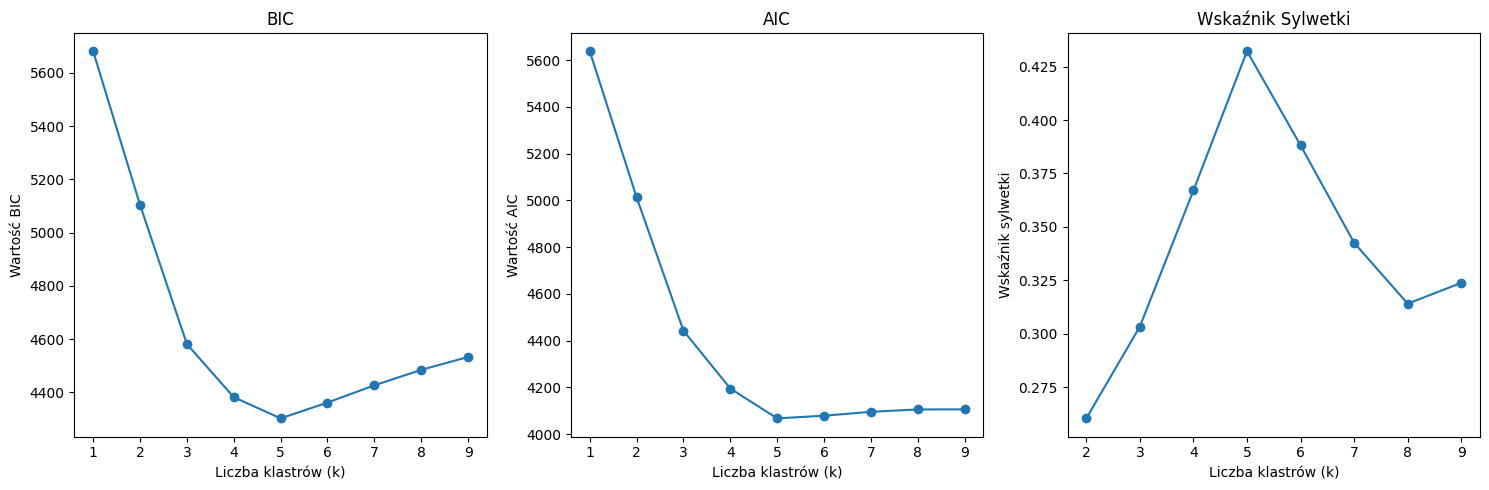

In [8]:
# Zakres liczby klastrów, który chcemy przetestować
ks = range(1, 10)  # sprawdzamy od 1 do 9 klastrów

bic_scores = []
aic_scores = []
silhouette_scores = []

for k in ks:
    # Tworzymy i dopasowujemy model GMM z k klastrami
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=0)
    gmm.fit(X_new)

    # Zapisujemy wartości BIC i AIC
    bic_scores.append(gmm.bic(X_new))
    aic_scores.append(gmm.aic(X_new))

    # Współczynnik sylwetki można obliczyć tylko, jeśli k > 1
    if k > 1:
        labels = gmm.predict(X_new)
        s_score = silhouette_score(X_new, labels)
        silhouette_scores.append(s_score)
    else:
        silhouette_scores.append(np.nan)  # dla k=1 nie definiujemy silhouette score

# Wizualizacja wyników
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# BIC
ax[0].plot(ks, bic_scores, marker='o')
ax[0].set_title('BIC')
ax[0].set_xlabel('Liczba klastrów (k)')
ax[0].set_ylabel('Wartość BIC')

# AIC
ax[1].plot(ks, aic_scores, marker='o')
ax[1].set_title('AIC')
ax[1].set_xlabel('Liczba klastrów (k)')
ax[1].set_ylabel('Wartość AIC')

# Silhouette
ax[2].plot(ks, silhouette_scores, marker='o')
ax[2].set_title('Wskaźnik Sylwetki')
ax[2].set_xlabel('Liczba klastrów (k)')
ax[2].set_ylabel('Wskaźnik sylwetki')

plt.tight_layout()
plt.show()

#Wyniki dla danych 3D z 5 klastrami
Dla wygenerowanego zbioru danych 3D z 5 klastrami otrzymaliśmy, że BIC oraz AIC osiągają minimum dla 5 klastrów, natomiast wskaźńik sylwetki osiąga maksimum dla 5 klastrów, zatem na podstawie tych trzech wskaźników otrzymujemy, że oryginalne dane są podzielone na prawdopodobnie 5 klastrów, co jest zgodne ze sposobem wygenerowania tych danych.